# Uncalibrated workflow

There is no stereo calibration in this case; we *do* know the cameras' intrinsics.

Steps:

0. Prerequisites
    1. Calibrate cameras separately to get $K_1$, $K_2$.
    2. Take a stereo photo pair of a static scene.
1. Detect and match features between the two images (e.g., SIFT, ORB).
2. Estimate the Fundamental matrix $F$ between the images via `cv.findFundamentalMat`.
3. Compute the essential matrix $$ E = K_2^TFK_1.$$
4. Recover the relative pose $\left(R,t\right)$ of the cameras via `cv.recoverPose(E, ...)`.
5. (Optional) Draw the epipolar lines on the images, using $F$.

## 0 - Prerequisites

### 0.1 - Calibrate cameras

Obtain $K_1$ and $K_2$ by calibrating the cameras independently.

In [6]:
import cv2 as cv
import glob
import matplotlib.pyplot as plt
import numpy as np


def calibrate_camera(images: list[str]):
    """Calibrate a single camera with a set of chessboard images."""
    # Checkerboard config
    CHECKERBOARD = (9, 6)
    SQUARE_SIZE = 0.023 # 2.3cm

    # Prepare 3D object points
    objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[:, :2] = (
        np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1,2) * SQUARE_SIZE
    )

    # Arrays to store points
    objpoints = []      # 3D points in real world space
    imgpoints = []      # 2D points in image plane
    
    # Set up termination criteria for corner subpixel refinement
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Find the chessboard's interior corners
        ret, corners = cv.findChessboardCorners(gray, patternSize=CHECKERBOARD, corners=None)

        if ret:
            # If corners were successfully found
            # Add object points
            objpoints.append(objp)  # same for every image, since we know the geometry

            # Refine the detected image corners, and add them
            corners2 = cv.cornerSubPix(
                image=gray,
                corners=corners,
                winSize=(11, 11),
                zeroZone=(-1, -1),
                criteria=criteria,
            )
            imgpoints.append(corners2)
        else:
            print(f"Failed to detect chessboard in image '{fname}'.")
        
        objpoints = [objp for objp in objpoints if objp is not None]
        imgpoints = [imgp for imgp in imgpoints if imgp is not None]

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
        objectPoints=objpoints,
        imagePoints=imgpoints,
        imageSize=gray.shape[::-1],
        cameraMatrix=None,  # We want to fit this!
        distCoeffs=None,    # We want to fit this!
    )
    # ret - return code
    # mtx - camera intrinsics matrix
    # dist - distortion coefficients
    # rvecs - (extrinsic) rotation vectors
    # tvecs - (extrinsic) translation vectors

    # Calculate the reprojection error
    mean_error = 0.0
    for i in range(len(objpoints)):
        # Use the determined parameters to re-project the object points
        imgpoints_proj, _ = cv.projectPoints(
            objectPoints=objpoints[i],
            rvec=rvecs[i],
            tvec=tvecs[i],
            cameraMatrix=mtx,
            distCoeffs=dist,
        )
        # Calculate the norm
        error = cv.norm(imgpoints[i], imgpoints_proj, cv.NORM_L2) / len(imgpoints_proj)
        mean_error += error

    mean_error /= len(objpoints)

    print(f"Mean reprojection error: {mean_error:0.2f}")

    return ret, mtx, dist, rvecs, tvecs


def print_mtx(mtx: np.ndarray):
    if not mtx.shape == (3,3):
        raise ValueError(f"Camera intrinsics matrix should have shape (3,3); got {mtx.shape}")
    print(f"[[ {int(mtx[0][0]):^6d}  {int(mtx[0][1]):^6d}  {int(mtx[0][2]):^6d} ]")
    print(f" [ {int(mtx[1][0]):^6d}  {int(mtx[1][1]):^6d}  {int(mtx[1][2]):^6d} ]")
    print(f" [ {int(mtx[2][0]):^6d}  {int(mtx[2][1]):^6d}  {int(mtx[2][2]):^6d} ]]")

In [3]:
FOLDER = "data/chessboard"

images_calib1 = sorted(glob.glob(f"{FOLDER}/left_*.jpg"))
_, mat1, dist1, _, _ = calibrate_camera(images_calib1)
# save the fitted parameters
np.savez(
    "K_left.npz",
    mat=mat1,
    distCoeffs=dist1,
)

images_calib2 = sorted(glob.glob(f"{FOLDER}/right_*.jpg"))
_, mat2, dist2, _, _ = calibrate_camera(images_calib2)
# save the fitted parameters
np.savez(
    "K_right.npz",
    mat=mat2,
    distCoeffs=dist2,
)

Mean reprojection error: 0.09
Failed to detect chessboard in image 'data/chessboard\right_11.jpg'.
Mean reprojection error: 0.10


In [5]:
# Print the intrinsics, for inspection
print("Camera 1:")
print_mtx(mat1)
print("\nCamera 2:")
print_mtx(mat2)

Camera 1:
[[  1025     0      655   ]
 [   0      1031    393   ]
 [   0       0       1    ]]

Camera 2:
[[  1023     0      665   ]
 [   0      1023    389   ]
 [   0       0       1    ]]


### 0.2 - Select a stereo image pair

These were taken already, so here we just load and display them.

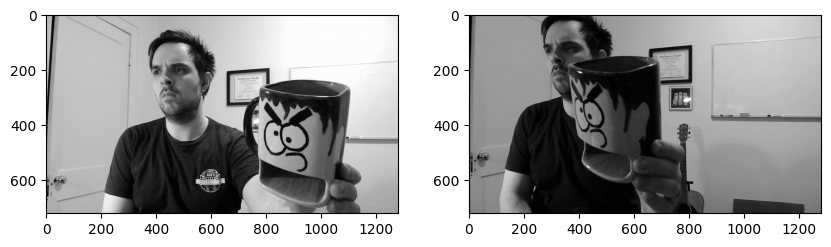

In [7]:
img_idx = 3
FOLDER = "data/stereo"
img_l = cv.imread(f"{FOLDER}/left_{img_idx}.jpg")
img_l = cv.cvtColor(img_l, cv.COLOR_BGR2GRAY)
img_r = cv.imread(f"{FOLDER}/right_{img_idx}.jpg")
img_r = cv.cvtColor(img_r, cv.COLOR_BGR2GRAY)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img_l, 'gray')
ax[1].imshow(img_r, 'gray')
plt.show()

## 1. Feature detection and matching

Optional: mask the images to regions of interest in order to keep matches clean.

In [ ]:
# fig = plt.figure()
# x, y, w, h = 300, 100, 250, 300

# mask_l = np.zeros(img_l.shape[:2], dtype=np.uint8)
# cv.rectangle(mask_l, (x,y), (x+w, y+h), 255, thickness=-1)

# # visualize the mask
# mask_color = cv.cvtColor(mask_l, cv.COLOR_GRAY2BGR)
# overlay_color = (255, 255, 255)
# overlay = np.zeros_like(mask_color)
# overlay[mask_l==255] = overlay_color
# alpha = 0.3
# img_overlay = cv.addWeighted(cv.cvtColor(img_l, cv.COLOR_GRAY2BGR), alpha=1-alpha, src2=overlay, beta=alpha, gamma=0)

# plt.imshow(img_overlay)
# plt.show()

In [ ]:
# fig = plt.figure()
# x, y, w, h = 200, 50, 250, 300

# mask_r = np.zeros(img_r.shape[:2], dtype=np.uint8)
# cv.rectangle(mask_r, (x,y), (x+w, y+h), 255, thickness=-1)

# # visualize the mask
# mask_color = cv.cvtColor(mask_r, cv.COLOR_GRAY2BGR)
# overlay_color = (255, 255, 255)
# overlay = np.zeros_like(mask_color)
# overlay[mask_r==255] = overlay_color
# alpha = 0.3
# img_overlay = cv.addWeighted(cv.cvtColor(img_r, cv.COLOR_GRAY2BGR), alpha=1-alpha, src2=overlay, beta=alpha, gamma=0)

# plt.imshow(img_overlay)
# plt.show()

In [8]:
def spatial_nms(kp, matches, grid_size=20):
    """Perform simple non-maximal suppression on the matches.
    This prevents us from getting multiple matches representing
    very close pixel areas.
    """
    used_cells = set()
    filtered_matches = []

    for m in sorted(matches, key=lambda x: x.distance):
        x, y = map(int, kp[m.queryIdx].pt)
        cell = (x // grid_size, y // grid_size)
        if cell not in used_cells:
            filtered_matches.append(m)
            used_cells.add(cell)
    return filtered_matches

Found 84 matches.


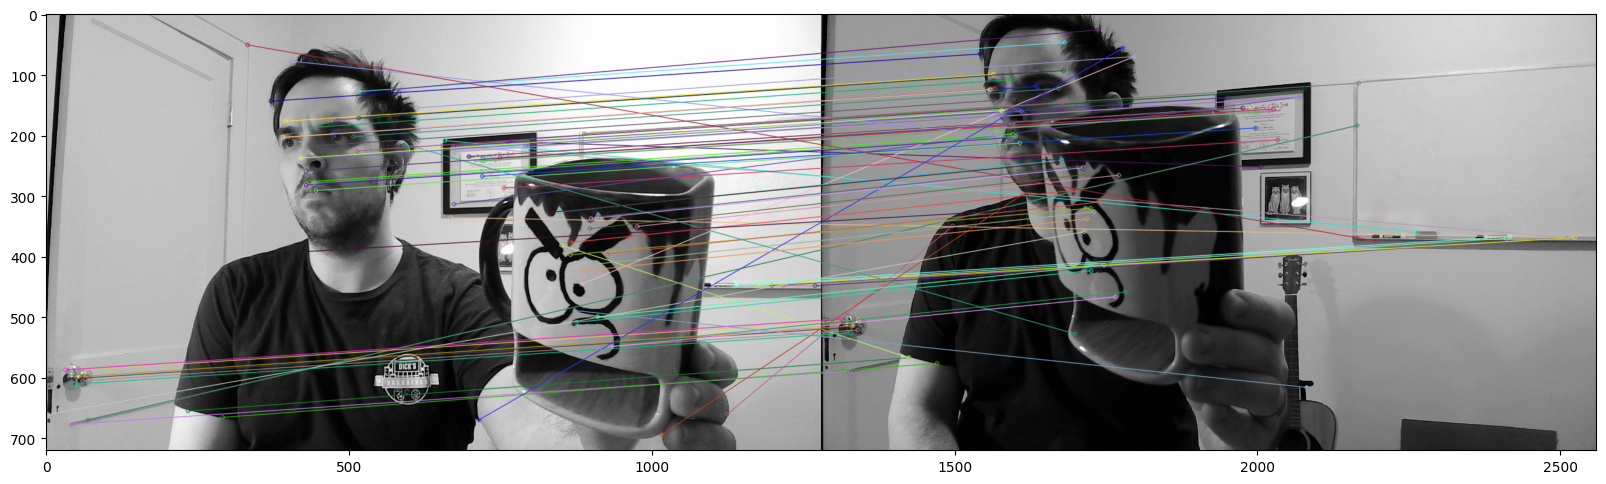

In [9]:
# Detect SIFT features
sift = cv.SIFT_create()
kp_l, desc_l = sift.detectAndCompute(img_l, None) # mask_l)
kp_r, desc_r = sift.detectAndCompute(img_r, None) # mask_r)

# Do FLANN matching
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc_l, desc_r, k=2)

pts_l, pts_r = list(), list()
# Filter via Lowe's ratio test to remove unreliable (poor) matches
thresh = 0.7
good_matches = [m for (m,n) in matches if m.distance < thresh * n.distance]

# Filter via spatial NMS on good matches to remove redudant matches
filtered_matches = spatial_nms(kp_l, good_matches, grid_size=20)

# Extract points from the filtered matches
pts_l = np.float32([kp_l[m.queryIdx].pt for m in filtered_matches])
pts_r = np.float32([kp_r[m.trainIdx].pt for m in filtered_matches])

# Quickly view the matches
print(f"Found {len(filtered_matches)} matches.")
img_matches = cv.drawMatches(
    img_l, kp_l, img_r, kp_r, filtered_matches, None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

fig = plt.figure(figsize=(20, 10))
plt.imshow(img_matches)
plt.show()

Note that some of the matches look accurate, but others are completely spurious. Thus we will need to robustly estimate $F$.

## 2. Estimate Fundamental Matrix $F$

Recall that for a pair of corresponding image points $\left(x_1, x_2\right)$ in the left and right images, the epipolar constraint must hold: $$ x_2^T F x_1 = 0.$$ This means that the point $x_2$ in the right image must lie on the epipolar line generated by $x_1$ via the matrix $F$.

Since real feature matches are noisy and contain outlies (spurious matches), we cannot solve for $F$ exactly. Instead, we can estimate it using robust methods like RANSAC.

In [19]:
F, mask = cv.findFundamentalMat(
    points1=pts_l,
    points2=pts_r,
    method=cv.FM_RANSAC,
    ransacReprojThreshold=1.0,
    confidence=0.99,
)

# Take only the inliers
pts_l = pts_l[mask.ravel() == 1]
pts_r = pts_r[mask.ravel() == 1]

print(f"Filtered down to {len(pts_l)} inlier matches")

print("Fundamental matrix:")
print(F)

Filtered down to 38 inlier matches
Fundamental matrix:
[[ 8.64983873e-09 -4.50095744e-07  1.20629418e-05]
 [-9.48219842e-08  1.33508788e-06  1.26451307e-02]
 [ 2.50808325e-04 -1.32340000e-02  1.00000000e+00]]


In [11]:
# # Draw epilines on second image
# def drawlines(img1, img2, lines, pts1, pts2):
#     """
#     img1 - image on which we draw epilines from points in img2
#     """
#     r, c = img1.shape
    
#     # Back to color
#     img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
#     img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)

#     for r, pt1, pt2 in zip(lines, pts1, pts2):
#         color = tuple(np.random.randint(0,255,3).tolist())
#         x0, y0 = map(int, [0, -r[2]/r[1]])
#         x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])

#         img1 = cv.line(img1, (x0, y0), (x1, y1), color, 1)
#         img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
#         img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
#     return img1, img2

# # Find epilines corresponding to points in second image,
# # and draw the lines on the first image
# lines_l = cv.computeCorrespondEpilines(pts_r.reshape(-1,1,2), 2, F)
# lines_l = lines_l.reshape(-1,3)
# img5, img6 = drawlines(img_l, img_r, lines_l, pts_l, pts_r)

# lines_r = cv.computeCorrespondEpilines(pts_l.reshape(-1,1,2), 1, F)
# lines_r = lines_r.reshape(-1,3)
# img7, img8 = drawlines(img_r, img_l, lines_r, pts_r, pts_l)

In [12]:
# fig = plt.figure(figsize=(20,10))
# fig.add_subplot(121)
# plt.imshow(img5)
# fig.add_subplot(122)
# plt.imshow(img7)
# plt.show()

## 3. Compute the essential matrix $E$

The essential matrix $E$ is obtained by using the camera intrinsics $K_1$ and $K_2$ to write the epipolar constraint in terms of the normalized image plane coordinates, instead of the pixel coordinates. Recall that for pixel locations $x_1$ and $x_2$ in the left and right images, we have the rays (homogeneous points in $\mathbb{P}^2$) $\tilde{x}_1$ and $\tilde{x}_2$ given by $$x_1 = K_1\tilde{x}_1 $$ and $$ x_2= K_2 \tilde{x_2}. $$ Substituting these into the epipolar constraint gives us $$ \tilde{x}_2^T K_2^T F K_1 \tilde{x}_1 = 0,$$ or $$ \tilde{x}_2^T E \tilde{x}_1 = 0$$ where $E = K_2^T F K_1$ is the essential matrix.


In [20]:
E = mat2.T @ F @ mat1

print("Essential matrix:")
print(E)

Essential matrix:
[[ 9.07646979e-03 -4.75067435e-01 -1.62984345e-01]
 [-9.95495581e-02  1.40987805e+00  1.34170734e+01]
 [ 2.25239063e-01 -1.34254896e+01  9.62513508e-01]]


## 4. Recover the pose of the cameras

From above, we see that $F$ includes ("encodes") the intrinsics of both cameras as well as the extrinsic geometry between the cameras.

Given the intrinsic calibration, we can "factor" the intrinsics out of $F$ by moving to $E$, which encodes only the extrinsics. From the math (not written out here), $E$ can be expressed as $$ E = \left[t\right]_{\times} R $$ where $\left(R,t\right)$ is the relative pose between the cameras.

Given $E$, we can recover the pose $\left(R,t\right)$ up to scale.

In [23]:
ret, E_ref, R, t, mask = cv.recoverPose(
    points1=pts_l.astype(np.float32),
    points2=pts_r.astype(np.float32),
    cameraMatrix1=mat1,
    cameraMatrix2=mat2,
    distCoeffs1=dist1,
    distCoeffs2=dist2,
    E=E,
)
# ret - return code
# E_ref - refined version of the input E (or an estimate, if not passed)
# R - extrinsic rotation
# t - extrinsic translation (up to scale)
# mask - indicates inliers of the points

In [28]:
print("Extrinsic rotation (R):")
print(R)

print("Extrinsic translation (t):")
print(t.flatten())

Extrinsic rotation (R):
[[ 0.99913171  0.00434636  0.04143584]
 [-0.00134112  0.99738339 -0.0722812 ]
 [-0.04164158  0.07216287  0.99652321]]
Extrinsic translation (t):
[-0.99988533 -0.00719543 -0.01332509]


Some notes:

The recovered rotation is almost the identity matrix, indicating that the cameras are not rotated significantly relative to one another.

The recovered translation is almost entirely in the (negative) $x$-direction. The convention is that $-x$ points to the left of the camera's viewing direction, so this implies that the cameras were side-by-side.

Both of these conclusions were true of the camera setup, so this result was expected.